This notebook performs downstream Drug Response Prediction with the augmented cell line data and patient datasets. Uses a neural network to perform DRP.

In [1]:
import pandas as pd
import numpy as np

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

In [3]:
import sys
sys.path.append("../src/tab_ddpm/")

In [4]:
device = torch.device("cuda:0")

In [5]:
torch.manual_seed(0)

In [6]:
sample_id = 2

#### Load Datasets

In [7]:
tcga_train_df = pd.read_csv(f"../data/diffusion_pretraining/tcga_diffusion_train_sample{sample_id}.csv", index_col=0)
tcga_train_df.shape

(476, 7776)

In [8]:
tcga_test_df = pd.read_csv(f"../data/diffusion_pretraining/tcga_diffusion_test_sample{sample_id}.csv", index_col=0)
tcga_test_df.shape

(120, 7776)

In [9]:
# augmented_cl_df = pd.read_csv(f"/data/ajayago/druid/intermediate/cs6220/sample{sample_id}/augmented_cl_joint_UDA.csv", index_col=0) # only UDA + LDM
# augmented_cl_df = pd.read_csv(f"/data/ajayago/druid/intermediate/cs6220/sample{sample_id}/augmented_cl_clconditioned.csv", index_col=0) # no UDA, only conditioning
# augmented_cl_df = pd.read_csv(f"/data/ajayago/druid/intermediate/cs6220/sample{sample_id}/augmented_cl_clconditioned_uda.csv", index_col=0) # all possible losses
augmented_cl_df = pd.read_csv(f"/data/ajayago/druid/intermediate/cs6220/sample{sample_id}/augmented_cl_clconditioned_uda_v2.csv", index_col=0) # without KLD, MSE mean in training. Only uses Gaussian loss from TDDPM and coral loss
print(augmented_cl_df.shape)
augmented_cl_df

(1744, 7776)


,ABL1_piu_max,ACVR1B_piu_max,AKT1_piu_max,AKT2_piu_max,AKT3_piu_max,ALK_piu_max,ALOX12B_piu_max,APC_piu_max,AR_piu_max,ARAF_piu_max,...,U2AF1_benign_count,VEGFA_benign_count,VHL_benign_count,WHSC1_benign_count,WHSC1L1_benign_count,WT1_benign_count,XPO1_benign_count,XRCC2_benign_count,ZNF217_benign_count,ZNF703_benign_count
ACH-000702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACH-002084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACH-001704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACH-000713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACH-000064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-000106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACH-000943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACH-000413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACH-002226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Load response files

In [10]:
cl_responses_df = pd.read_csv("/data/ajayago/copied_from_cdal1/yiming_data_folder/dataset/CellLine/patient_auc.csv")
cl_responses_df

,depmap_id,drug_name,auc
0,ACH-000001,JW-7-24-1,0.778432
1,ACH-000002,JW-7-24-1,0.788327
2,ACH-000004,JW-7-24-1,0.737630
3,ACH-000006,JW-7-24-1,0.176396
4,ACH-000007,JW-7-24-1,0.569751
...,...,...,...
226791,ACH-001702,SL 0101-1,0.958591
226792,ACH-001703,SL 0101-1,0.497201
226793,ACH-001711,SL 0101-1,0.815928
226794,ACH-001715,SL 0101-1,0.981441


In [11]:
patient_responses_df = pd.read_csv("/data/ajayago/copied_from_cdal1/ajayago_home_folder/processed/TCGA_drug_response_010222.csv")
patient_responses_df

,patient.arr,drug.name,response,response_cat,drug
0,TCGA-G2-A2EC,Methotrexate,Partial Response,1,METHOTREXATE
1,TCGA-G2-A2EC,Doxorubicin,Partial Response,1,DOXORUBICIN
2,TCGA-G2-A2EC,Vinblastine,Partial Response,1,VINBLASTINE
3,TCGA-G2-A2EC,Cisplatin,Partial Response,1,CISPLATIN
4,TCGA-G2-A2EJ,Paclitaxel,Stable Disease,0,PACLITAXEL
...,...,...,...,...,...
1244,TCGA-BG-A0VZ,Cisplatin,Complete Response,1,CISPLATIN
1245,TCGA-BG-A0VZ,Paclitaxel,Complete Response,1,PACLITAXEL
1246,TCGA-BG-A0VZ,Doxorubicin,Complete Response,1,DOXORUBICIN
1247,TCGA-BG-A0VT,Carboplatin,Complete Response,1,CARBOPLATIN


In [12]:
patient_responses_df["drug"].value_counts()

drug
CISPLATIN             206
5-FLUOROURACIL        125
CARBOPLATIN           117
PACLITAXEL            113
CYCLOPHOSPHAMIDE       69
                     ... 
E7389                   1
CARMUSTINE              1
TEMOZOLOMIDE            1
ERIBULIN                1
METHYLPREDNISOLONE      1
Name: count, Length: 69, dtype: int64

In [13]:
patient_responses_df[patient_responses_df["patient.arr"].isin(tcga_test_df.index)].drug.value_counts()

drug
CISPLATIN           39
PACLITAXEL          34
5-FLUOROURACIL      29
CARBOPLATIN         27
CYCLOPHOSPHAMIDE    18
LEUCOVORIN          18
DOXORUBICIN         14
DOCETAXEL           13
GEMCITABINE         12
ETOPOSIDE            9
OXALIPLATIN          9
VINORELBINE          7
CAPECITABINE         6
CETUXIMAB            5
PEMETREXED           5
IRINOTECAN           4
EPIRUBICIN           4
ANASTROZOLE          3
METHOTREXATE         2
ERLOTINIB            2
TRASTUZUMAB          2
VINBLASTINE          2
TAMOXIFEN            2
GOSERELIN            1
FULVESTRANT          1
LETROZOLE            1
TOPOTECAN            1
FOTEMUSTINE          1
LOMUSTINE            1
DACARBAZINE          1
VEMURAFENIB          1
DIDOX                1
MITOMYCIN-C          1
Name: count, dtype: int64

In [14]:
patient_responses_df[patient_responses_df["patient.arr"].isin(tcga_train_df.index)].drug.value_counts()

drug
CISPLATIN             167
5-FLUOROURACIL         96
CARBOPLATIN            90
PACLITAXEL             79
CYCLOPHOSPHAMIDE       51
                     ... 
PNU-159548              1
RESIQUIMOD              1
ERIBULIN                1
METHYLPREDNISOLONE      1
TOPOTECAN               1
Name: count, Length: 68, dtype: int64

In [15]:
train_tcga_with_response = patient_responses_df[patient_responses_df["patient.arr"].isin(tcga_train_df.index)].reset_index(drop=True)
train_tcga_with_response

,patient.arr,drug.name,response,response_cat,drug
0,TCGA-G2-A2EC,Methotrexate,Partial Response,1,METHOTREXATE
1,TCGA-G2-A2EC,Doxorubicin,Partial Response,1,DOXORUBICIN
2,TCGA-G2-A2EC,Vinblastine,Partial Response,1,VINBLASTINE
3,TCGA-G2-A2EC,Cisplatin,Partial Response,1,CISPLATIN
4,TCGA-G2-A2EJ,Paclitaxel,Stable Disease,0,PACLITAXEL
...,...,...,...,...,...
968,TCGA-E6-A8L9,Carboplatin,Complete Response,1,CARBOPLATIN
969,TCGA-2E-A9G8,Paclitaxel,Complete Response,1,PACLITAXEL
970,TCGA-2E-A9G8,Carboplatin,Complete Response,1,CARBOPLATIN
971,TCGA-BG-A0VT,Carboplatin,Complete Response,1,CARBOPLATIN


In [16]:
test_tcga_with_response = patient_responses_df[patient_responses_df["patient.arr"].isin(tcga_test_df.index)].reset_index(drop=True)
test_tcga_with_response

,patient.arr,drug.name,response,response_cat,drug
0,TCGA-G2-A2EF,Methotrexate,Partial Response,1,METHOTREXATE
1,TCGA-G2-A2EF,Vinblastine,Partial Response,1,VINBLASTINE
2,TCGA-G2-A2EF,Doxorubicin,Partial Response,1,DOXORUBICIN
3,TCGA-G2-A2EF,Cisplatin,Partial Response,1,CISPLATIN
4,TCGA-DK-A3IQ,Gemcitabine,Stable Disease,0,GEMCITABINE
...,...,...,...,...,...
271,TCGA-QS-A8F1,Carboplatin,Clinical Progressive Disease,0,CARBOPLATIN
272,TCGA-QS-A8F1,Paclitaxel,Clinical Progressive Disease,0,PACLITAXEL
273,TCGA-BG-A0VZ,Cisplatin,Complete Response,1,CISPLATIN
274,TCGA-BG-A0VZ,Paclitaxel,Complete Response,1,PACLITAXEL


In [17]:
drug_fp = pd.read_csv("/data/ajayago/copied_from_cdal1/ajayago_home_folder/processed/drug_morgan_fingerprints.csv", index_col = 0)
drug_fp

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
drug_name,,,,,,,,,,,,,,,,,,,,,
JW-7-24-1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
KIN001-260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NSC-87877,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
GNE-317,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NAVITOCLAX,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LGH447,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRASTUZUMAB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WNT974,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
set(train_tcga_with_response["drug"]) - set(drug_fp.index)

{'ALDESLEUKIN',
 'ANASTROZOLE',
 'BCG',
 'CAPECITABINE',
 'CARBOPLATIN',
 'CYCLOSPORINE',
 'DEXAMETHASONE',
 'DIDOX',
 'E7389',
 'ERIBULIN',
 'EXEMESTANE',
 'FOLFIRI',
 'FOLFOX',
 'FOTEMUSTINE',
 'GOSERELIN',
 'GP100',
 'HYDROCORTISONE',
 'IFOSFAMIDE',
 'LETROZOLE',
 'LEUCOVORIN',
 'LEUPROLIDE',
 'LOMUSTINE',
 'MELPHALAN',
 'METHYLPREDNISOLONE',
 'MYCOPHENOLIC ACID',
 'ONDANSETRON',
 'PAMIDRONATE',
 'PEGFILGRASTIM',
 'PNU-159548',
 'PX-866',
 'REGORAFENIB',
 'RESIQUIMOD',
 'TOREMIFENE',
 'VEMURAFENIB'}

In [19]:
set(test_tcga_with_response["drug"]) - set(drug_fp.index)

{'ANASTROZOLE',
 'CAPECITABINE',
 'CARBOPLATIN',
 'DIDOX',
 'FOTEMUSTINE',
 'GOSERELIN',
 'LETROZOLE',
 'LEUCOVORIN',
 'LOMUSTINE',
 'VEMURAFENIB'}

Plan:

* Baseline: Train a model on train patient data + drug fingerprints and predict the response for the (patient, drug) pair.
* Add all cell lines and assign pseudo labels using the patient model from baseline - concat both datasets and train another model.
* Weak supervision + subset selection on cell lines - use this with patient data to train another model

Evaluation: Classification metrics on the patient test dataset.

In [20]:
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score

In [21]:
# Held out TCGA dataset
test_features = []
test_y = []
drugs = []
for idx, row in test_tcga_with_response.iterrows():
    if row["drug"] in drug_fp.index:
        row_inp = []
        row_inp.extend(tcga_test_df.loc[row["patient.arr"]].values)
        row_inp.extend(drug_fp.loc[row["drug"]].values)
        test_y.append(row["response_cat"])
        test_features.append(row_inp)
        drugs.append(row["drug"])

In [22]:
test_features_tensor = torch.tensor(test_features)
test_y_tensor = torch.tensor(test_y)
print(test_features_tensor.shape, test_y_tensor.shape)

torch.Size([216, 9824]) torch.Size([216])


#### Baseline Model

In [23]:
train_features_all = []
train_y_all = []
for idx, row in train_tcga_with_response.iterrows():
    if row["drug"] in drug_fp.index:
        row_inp = []
        row_inp.extend(tcga_train_df.loc[row["patient.arr"]].values)
        row_inp.extend(drug_fp.loc[row["drug"]].values)
        train_y_all.append(row["response_cat"])
        train_features_all.append(row_inp)

In [24]:
val_features = train_features_all[int(0.8 * len(train_features_all)):]
val_y = train_y_all[int(0.8 * len(train_features_all)):]
train_features = train_features_all[:int(0.8 * len(train_features_all))]
train_y = train_y_all[:int(0.8 * len(train_features_all))]

In [25]:
len(train_features), len(test_features), len(val_features)

(596, 216, 150)

In [26]:
train_features_tensor = torch.tensor(train_features)
train_y_tensor = torch.tensor(train_y)
print(train_features_tensor.shape, train_y_tensor.shape)

torch.Size([596, 9824]) torch.Size([596])


In [27]:
val_features_tensor = torch.tensor(val_features)
val_y_tensor = torch.tensor(val_y)
print(val_features_tensor.shape, val_y_tensor.shape)

torch.Size([150, 9824]) torch.Size([150])


In [28]:
class BaseLineNN(nn.Module):
    def __init__(self, in_dim = 9824, hidden_size=64, out_dim = 1):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, hidden_size)
        self.linear2 = nn.Linear(hidden_size, out_dim)

    def forward(self, x):
        x = self.linear1(x)
        x = nn.ReLU()(x)
        x = self.linear2(x)
        return x

In [29]:
nn_baseline = BaseLineNN()

In [30]:
criterion = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(nn_baseline.parameters(), lr = 1e-3)

In [31]:
train_y_tensor.dtype

torch.int64

In [32]:
# training 
train_losses = []
for i in range(100):
    optim.zero_grad()
    y_pred = nn_baseline(train_features_tensor.to(dtype=torch.float32))
    loss = criterion(y_pred, train_y_tensor.view(-1, 1).to(dtype=torch.float32))
    loss.backward()
    optim.step()

    with torch.no_grad():
        val_loss = criterion(nn_baseline(val_features_tensor.to(dtype=torch.float32)), val_y_tensor.view(-1, 1).to(dtype=torch.float32))

    print(f"Epoch {i}: Training loss: {loss.detach().item()} |  Validation loss: {val_loss.detach().item()}")
    train_losses.append(loss.detach().item())

Epoch 0: Training loss: 0.7071214914321899 |  Validation loss: 0.6650648713111877
Epoch 1: Training loss: 0.7115353941917419 |  Validation loss: 0.6527093052864075
Epoch 2: Training loss: 0.6750816702842712 |  Validation loss: 0.647904098033905
Epoch 3: Training loss: 0.6304271817207336 |  Validation loss: 0.6620051860809326
Epoch 4: Training loss: 0.6353586912155151 |  Validation loss: 0.6603531241416931
Epoch 5: Training loss: 0.6251766085624695 |  Validation loss: 0.6472169756889343
Epoch 6: Training loss: 0.6025330424308777 |  Validation loss: 0.6394056081771851
Epoch 7: Training loss: 0.5830768942832947 |  Validation loss: 0.6390070915222168
Epoch 8: Training loss: 0.5808665752410889 |  Validation loss: 0.6407021284103394
Epoch 9: Training loss: 0.5724136829376221 |  Validation loss: 0.6440936326980591
Epoch 10: Training loss: 0.5548773407936096 |  Validation loss: 0.6525616645812988
Epoch 11: Training loss: 0.5399544835090637 |  Validation loss: 0.6620950698852539
Epoch 12: Train

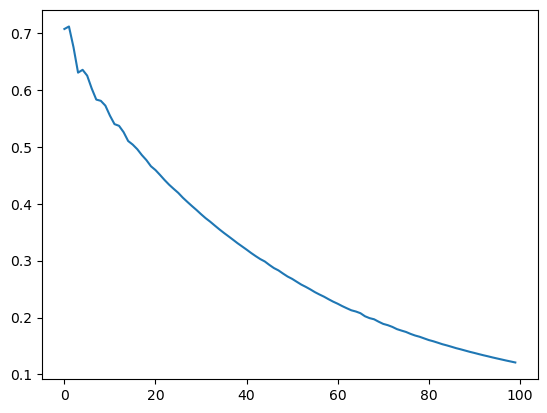

In [33]:
plt.plot(train_losses)

In [34]:
# inference
nn_baseline.eval()
y_test_pred = nn.Sigmoid()(nn_baseline(test_features_tensor.to(dtype=torch.float32)))
y_test_pred.shape

torch.Size([216, 1])

In [35]:
predictions = y_test_pred.detach().numpy().reshape(-1)
predictions.shape

(216,)

In [36]:
auroc = roc_auc_score(test_y, predictions)
auprc = average_precision_score(test_y, predictions)
print(f"AUROC: {auroc}, AUPRC: {auprc}")

AUROC: 0.46145789694176786, AUPRC: 0.6975902994996962


In [37]:
# per drug
res_df = pd.DataFrame(predictions, columns=["y_pred"])
res_df["y_true"] = test_y
res_df["drug"] = drugs
for d in res_df.drug.unique():
    try:
        subset_df = res_df[res_df.drug == d]
        auroc = roc_auc_score(subset_df["y_true"], subset_df["y_pred"])
        auprc = average_precision_score(subset_df["y_true"], subset_df["y_pred"])
        print(f"Drug {d} | AUROC = {auroc}, AUPRC = {auprc}")
        print(subset_df.shape)
        print(subset_df.y_true.value_counts())
    except:
        continue

Drug METHOTREXATE | AUROC = 1.0, AUPRC = 1.0
(2, 3)
y_true
1    1
0    1
Name: count, dtype: int64
Drug VINBLASTINE | AUROC = 1.0, AUPRC = 1.0
(2, 3)
y_true
1    1
0    1
Name: count, dtype: int64
Drug DOXORUBICIN | AUROC = 0.4545454545454546, AUPRC = 0.8431164794801158
(14, 3)
y_true
1    11
0     3
Name: count, dtype: int64
Drug CISPLATIN | AUROC = 0.41379310344827586, AUPRC = 0.7640010714688401
(39, 3)
y_true
1    29
0    10
Name: count, dtype: int64
Drug GEMCITABINE | AUROC = 0.38888888888888884, AUPRC = 0.5590909090909091
(12, 3)
y_true
0    6
1    6
Name: count, dtype: int64
Drug PACLITAXEL | AUROC = 0.45333333333333337, AUPRC = 0.712004256827989
(34, 3)
y_true
1    25
0     9
Name: count, dtype: int64
Drug 5-FLUOROURACIL | AUROC = 0.4, AUPRC = 0.6872551026221103
(29, 3)
y_true
1    20
0     9
Name: count, dtype: int64
Drug CYCLOPHOSPHAMIDE | AUROC = 0.59375, AUPRC = 0.936721040397511
(18, 3)
y_true
1    16
0     2
Name: count, dtype: int64
Drug DOCETAXEL | AUROC = 0.524999999999

In [38]:
(test_y_tensor == 0).sum()

tensor(62)

#### Model with all cell lines + pseudo labels and train patient data -- FOCUS

In [39]:
cl_aug_train_features = []
cl_aug_train_y = []
for idx, row in cl_responses_df.iterrows():
    if row["drug_name"] in drug_fp.index:
        row_inp = []
        row_inp.extend(augmented_cl_df.loc[row["depmap_id"]].values)
        row_inp.extend(drug_fp.loc[row["drug_name"]].values)
        cl_aug_train_y.append(row["auc"])
        cl_aug_train_features.append(row_inp)

In [40]:
len(cl_aug_train_features)

226796

In [41]:
cl_aug_train_features_tensor = torch.tensor(cl_aug_train_features)
cl_aug_train_features_tensor.shape

torch.Size([226796, 9824])

In [42]:
# np.save("/data/ajayago/druid/intermediate/cs6220/augmented_cl_features_nn_clconditioned.npy", np.array(cl_aug_train_features))

In [43]:
# Assign pseudo labels for cell lines using above NN Model
nn_baseline.eval()
cl_aug_train_y_pseudo = nn.Sigmoid()(nn_baseline(cl_aug_train_features_tensor.to(dtype=torch.float32))).detach()
cl_aug_train_y_pseudo.shape

torch.Size([226796, 1])

In [44]:
# pd.DataFrame(cl_aug_train_y_pseudo).to_csv("/data/ajayago/druid/intermediate/cs6220/augmented_cl_pseudolabels_nn_clconditioned.csv", index=False, header=False)

In [45]:
# Use pseudo labeled cell lines and patient train data to train
X_train = torch.cat((train_features_tensor, cl_aug_train_features_tensor), dim=0)
X_train

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [46]:
X_train.shape

torch.Size([227392, 9824])

In [47]:
y_train = torch.cat((train_y_tensor.view(-1, 1), cl_aug_train_y_pseudo), dim = 0)
y_train.shape

torch.Size([227392, 1])

In [90]:
del nn_augmented_full
nn_augmented_full = BaseLineNN()

In [91]:
criterion_aug = nn.BCEWithLogitsLoss()
optim_aug = torch.optim.Adam(nn_augmented_full.parameters(), lr = 1e-5)

In [92]:
# training 
train_losses = []
val_losses = []
for i in range(500):
    optim_aug.zero_grad()
    y_pred_aug = nn_augmented_full(X_train.to(dtype=torch.float32))
    loss_aug = criterion_aug(y_pred_aug, y_train.view(-1, 1).to(dtype=torch.float32))
    loss_aug.backward()
    optim_aug.step()

    with torch.no_grad():
        val_loss_aug = criterion_aug(nn_augmented_full(val_features_tensor.to(dtype=torch.float32)), val_y_tensor.view(-1, 1).to(dtype=torch.float32))

    val_losses.append(val_loss_aug.detach().item())

    if len(val_losses) > 2:
        if val_losses[-1]> val_losses[-2]:
            break
    print(f"Epoch {i}: Training loss: {loss_aug.detach().item()} |  Validation loss: {val_loss_aug.detach().item()}")
    train_losses.append(loss_aug.detach().item())

Epoch 0: Training loss: 0.6959549188613892 |  Validation loss: 0.690293550491333
Epoch 1: Training loss: 0.694668710231781 |  Validation loss: 0.68989098072052
Epoch 2: Training loss: 0.693427324295044 |  Validation loss: 0.6894963383674622
Epoch 3: Training loss: 0.6922285556793213 |  Validation loss: 0.6891093254089355
Epoch 4: Training loss: 0.6910709142684937 |  Validation loss: 0.6887291073799133
Epoch 5: Training loss: 0.6899538040161133 |  Validation loss: 0.688356876373291
Epoch 6: Training loss: 0.6888763308525085 |  Validation loss: 0.6879935264587402
Epoch 7: Training loss: 0.6878379583358765 |  Validation loss: 0.6876385807991028
Epoch 8: Training loss: 0.6868383288383484 |  Validation loss: 0.6872913837432861
Epoch 9: Training loss: 0.68587726354599 |  Validation loss: 0.6869552731513977
Epoch 10: Training loss: 0.6849547624588013 |  Validation loss: 0.6866257786750793
Epoch 11: Training loss: 0.684070348739624 |  Validation loss: 0.6863028407096863
Epoch 12: Training loss

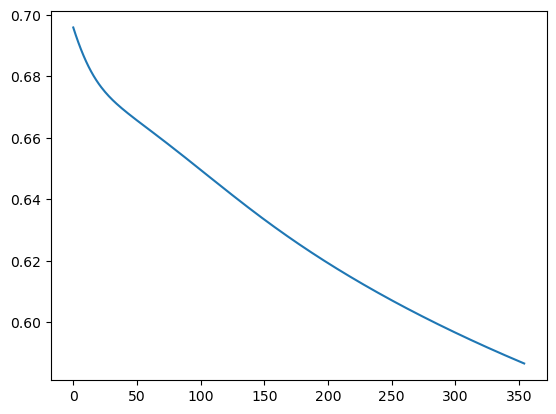

In [93]:
plt.plot(train_losses)

In [94]:
# inference
nn_augmented_full.eval()
y_test_pred = nn.Sigmoid()(nn_augmented_full(test_features_tensor.to(dtype=torch.float32)))
y_test_pred.shape

torch.Size([216, 1])

In [95]:
predictions = y_test_pred.detach().numpy().reshape(-1)
predictions.shape

(216,)

In [96]:
auroc = roc_auc_score(test_y, predictions)
auprc = average_precision_score(test_y, predictions)
print(f"AUROC: {auroc}, AUPRC: {auprc}")

AUROC: 0.49025974025974034, AUPRC: 0.6980536990137197


In [97]:
# per drug
res_df = pd.DataFrame(predictions, columns=["y_pred"])
res_df["y_true"] = test_y
res_df["drug"] = drugs

In [98]:
res_df

,y_pred,y_true,drug
0,0.643009,1,METHOTREXATE
1,0.711428,1,VINBLASTINE
2,0.673681,1,DOXORUBICIN
3,0.522673,1,CISPLATIN
4,0.587257,0,GEMCITABINE
...,...,...,...
211,0.676629,1,PACLITAXEL
212,0.687534,0,PACLITAXEL
213,0.533565,1,CISPLATIN
214,0.704346,1,PACLITAXEL


In [99]:
for d in res_df.drug.unique():
    try:
        subset_df = res_df[res_df.drug == d]
        auroc = roc_auc_score(subset_df["y_true"], subset_df["y_pred"])
        auprc = average_precision_score(subset_df["y_true"], subset_df["y_pred"])
        print(f"Drug {d} | AUROC = {auroc}, AUPRC = {auprc}")
        print(subset_df.shape)
        print(subset_df.y_true.value_counts())
    except:
        continue

Drug METHOTREXATE | AUROC = 1.0, AUPRC = 1.0
(2, 3)
y_true
1    1
0    1
Name: count, dtype: int64
Drug VINBLASTINE | AUROC = 1.0, AUPRC = 1.0
(2, 3)
y_true
1    1
0    1
Name: count, dtype: int64
Drug DOXORUBICIN | AUROC = 0.5151515151515151, AUPRC = 0.8369453778544689
(14, 3)
y_true
1    11
0     3
Name: count, dtype: int64
Drug CISPLATIN | AUROC = 0.45862068965517244, AUPRC = 0.7547571560223463
(39, 3)
y_true
1    29
0    10
Name: count, dtype: int64
Drug GEMCITABINE | AUROC = 0.5, AUPRC = 0.5994047619047619
(12, 3)
y_true
0    6
1    6
Name: count, dtype: int64
Drug PACLITAXEL | AUROC = 0.4088888888888889, AUPRC = 0.6928065889993036
(34, 3)
y_true
1    25
0     9
Name: count, dtype: int64
Drug 5-FLUOROURACIL | AUROC = 0.6722222222222223, AUPRC = 0.8360118199267816
(29, 3)
y_true
1    20
0     9
Name: count, dtype: int64
Drug CYCLOPHOSPHAMIDE | AUROC = 0.59375, AUPRC = 0.915236300668286
(18, 3)
y_true
1    16
0     2
Name: count, dtype: int64
Drug DOCETAXEL | AUROC = 0.35, AUPRC = 0

In [100]:
# for DRP comparison
drugs_drp = ["DOXORUBICIN", "CISPLATIN", "PACLITAXEL", "GEMCITABINE", "5-FLUOROURACIL", "DOCETAXEL", "CYCLOPHOSPHAMIDE"]
subset_df2 = res_df[res_df.drug.isin(drugs_drp)]
print(subset_df2.shape)
auroc = roc_auc_score(subset_df2["y_true"], subset_df2["y_pred"])
auprc = average_precision_score(subset_df2["y_true"], subset_df2["y_pred"])
print(f"AUROC = {auroc}, AUPRC = {auprc}")

(159, 3)
AUROC = 0.48300395256916995, AUPRC = 0.6980852221568477


In [101]:
subset_df2[subset_df2.drug == "CYCLOPHOSPHAMIDE"]["y_true"].value_counts()

y_true
1    16
0     2
Name: count, dtype: int64

### Experimental Phase
Trying weak supervision - combine outputs from multiple label function using MajorityVoting to assign labels.

In [60]:
# # trying another 4 supervised classifiers trained on patient data and predicting on CL augmented
# from sklearn.ensemble import RandomForestClassifier
# rf1 = RandomForestClassifier(random_state=42, n_estimators=50)
# rf2 = RandomForestClassifier(random_state=1, max_depth=10)
# rf3 = RandomForestClassifier(random_state=0)
# # rf4 = RandomForestClassifier(random_state=3, n_estimators=10)

In [61]:
# rf3.fit(train_features, train_y)

In [62]:
# with open("/data/ajayago/druid/intermediate/cs6220/rf3_augmented_cl_v2_pseudolabels.csv", "a") as f:
#     for idx, row in cl_responses_df.iterrows():
#         if row["drug_name"] in drug_fp.index:
#             row_inp = []
#             row_inp.extend(augmented_cl_df.loc[row["depmap_id"]].values)
#             row_inp.extend(drug_fp.loc[row["drug_name"]].values)
#             pred = rf3.predict(np.array(row_inp).reshape(1, -1))[0]
#             f.write(f"{pred}\n")
        

##### Combine weak labels from RF1, RF2, RF3 - Majority Voting

In [63]:
# rf1_pred = pd.read_csv("/data/ajayago/druid/intermediate/cs6220/rf1_augmented_cl_v2_pseudolabels.csv", header=None)
# rf2_pred = pd.read_csv("/data/ajayago/druid/intermediate/cs6220/rf2_augmented_cl_v2_pseudolabels.csv", header=None)
# rf3_pred = pd.read_csv("/data/ajayago/druid/intermediate/cs6220/rf3_augmented_cl_v2_pseudolabels.csv", header=None)

In [64]:
# import scipy.stats as st
# maj_labels = st.mode(np.concatenate((rf1_pred.values, rf2_pred.values, rf3_pred.values), axis = 1), axis = 1).mode

Train with these labels now

In [65]:
# cl_aug_train_features = []
# cl_aug_train_y = []
# for idx, row in cl_responses_df.iterrows():
#     if row["drug_name"] in drug_fp.index:
#         row_inp = []
#         row_inp.extend(augmented_cl_df.loc[row["depmap_id"]].values)
#         row_inp.extend(drug_fp.loc[row["drug_name"]].values)
#         cl_aug_train_y.append(maj_labels[idx])
#         cl_aug_train_features.append(row_inp)

In [66]:
# # Use pseudo labeled cell lines and patient train data to train
# cl_aug_features_tensor = torch.Tensor(cl_aug_train_features)

In [67]:
# X_train = torch.cat((train_features_tensor, cl_aug_features_tensor), dim=0)
# X_train

In [68]:
# y_train = torch.cat((train_y_tensor.view(-1, 1), torch.tensor(cl_aug_train_y).view(-1, 1)), dim = 0)

In [69]:
# del nn_augmented_full

In [70]:
# nn_augmented_full = BaseLineNN()

In [71]:
# criterion_aug = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3/4]*X_train.shape[0]))
# optim_aug = torch.optim.Adam(nn_augmented_full.parameters(), lr = 1e-4)

In [72]:
# # training 
# train_losses = []
# val_losses = []
# count = 0
# for i in range(500):
#     optim_aug.zero_grad()
#     y_pred_aug = nn_augmented_full(X_train.to(dtype=torch.float32))
#     loss_aug = criterion_aug(y_pred_aug, y_train.view(-1, 1).to(dtype=torch.float32))
#     loss_aug.backward()
#     optim_aug.step()

#     with torch.no_grad():
#         val_loss_aug = criterion_aug(nn_augmented_full(val_features_tensor.to(dtype=torch.float32)), val_y_tensor.view(-1, 1).to(dtype=torch.float32))

#     val_losses.append(val_loss_aug.detach().item())
#     print(f"Epoch {i}: Training loss: {loss_aug.detach().item()} |  Validation loss: {val_loss_aug.detach().item()}")
#     train_losses.append(loss_aug.detach().item())
#     if len(val_losses) > 2:
#         if val_losses[-1] > val_losses[-2]:
#             count += 1
#     if count > 3:
#         print("Converged")
#         break

In [73]:
# plt.plot(train_losses)

In [74]:
# # inference
# nn_augmented_full.eval()
# y_test_pred = nn.Sigmoid()(nn_augmented_full(test_features_tensor.to(dtype=torch.float32)))
# y_test_pred.shape

In [75]:
# predictions = y_test_pred.detach().numpy().reshape(-1)
# print(predictions.shape)
# auroc = roc_auc_score(test_y, predictions)
# auprc = average_precision_score(test_y, predictions)
# print(f"AUROC: {auroc}, AUPRC: {auprc}")

In [76]:
# # per drug
# res_df = pd.DataFrame(predictions, columns=["y_pred"])
# res_df["y_true"] = test_y
# res_df["drug"] = drugs

In [77]:
# for d in res_df.drug.unique():
#     try:
#         subset_df = res_df[res_df.drug == d]
#         auroc = roc_auc_score(subset_df["y_true"], subset_df["y_pred"])
#         auprc = average_precision_score(subset_df["y_true"], subset_df["y_pred"])
#         print(f"Drug {d} | AUROC = {auroc}, AUPRC = {auprc}")
#         print(subset_df.shape)
#         print(subset_df.y_true.value_counts())
#     except:
#         continue